<a href="https://colab.research.google.com/github/panimesh14/Deep-Learning-/blob/main/LSTM_RNN_based_Sequence_Modeling_for_Time_Series_Forecasting_for_Frozen_Deserts_Production_Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM RNN based Time-Series Forecast Model for Frozen Deserts Production Index

Monthly Frequency data for Production Index of Frozen Desserts that describes the production output in real measures.

In [243]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Data Loading

In [244]:
#Data Reading/Loading
df=pd.read_csv('Frozen_Dessert_Production.csv')
df.head(2)

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605


In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE       573 non-null    object 
 1   IPN31152N  573 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.1+ KB


In [246]:
df['DATE']=pd.to_datetime(df['DATE'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DATE       573 non-null    datetime64[ns]
 1   IPN31152N  573 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.1 KB


In [247]:
df.set_index('DATE',inplace=True) 
df.head(2)

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605


In [248]:
df.rename(columns={'IPN31152N':'Production'},inplace=True)

In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Production  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


# Data Exploration

In [250]:
df
#Monthly Production Data
#Frequency=1 Month 
#Production Data from 1st January 1972 to 9th September 2019

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632


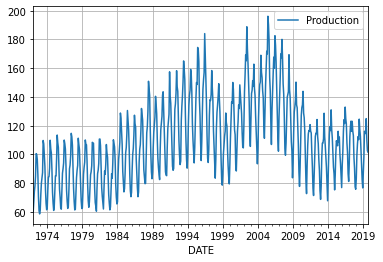

In [251]:
df.plot()
plt.grid(True)
#Seasonality in production shown by high frequency fluctuating peaks
#General relatively low frequency Periodic Trend underlying the high frequency fluctuations
#Year 1996 and 2004 show anomalous trends in production

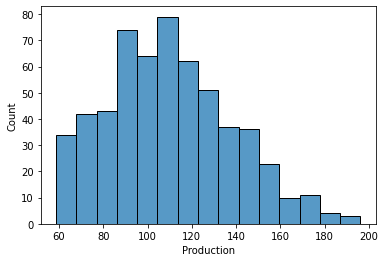

In [252]:
sns.histplot(df['Production'],bins=15)
#Overall Distributuon is right skewed from a symmetric Normal/Gaussian distribution
#Production Mode around 105  with mean and median greater in production value to to its right
#Median Production is around 107 and is shifted from symmetric normal 
#Mean Production for period is skewed to right and is greater than medianaround 109.89
#Overall Standard Deviation from mean around 27.95 units

In [253]:
#Production Distribution Numerical Stats
print('Mean of Distribution:',df['Production'].mean())
print('Median of Distribution:',df['Production'].median())
print('Standard Deviation of Production Index:',df['Production'].std())

Mean of Distribution: 109.89554537521815
Median of Distribution: 107.643
Standard Deviation of Production Index: 27.950571460177517


In [254]:
#Summary stats for Quick Overview
df.describe()
#Max production index around 196.17 units with minimum at 58.65 units

,Production
count,573.000000
mean,109.895545
std,27.950571
min,58.659800
25%,88.935500
50%,107.643000
75%,128.277700
max,196.173700


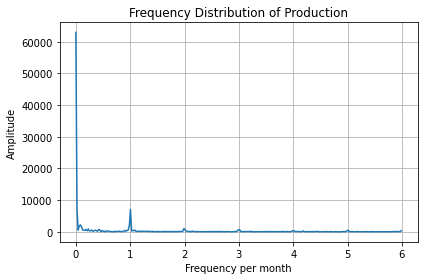

In [255]:
#help(np.fft)

N=len(df);#number of samples
dt=1/(12);#month
ind=(np.arange(0,N/2,1)).astype(int);
freq=ind/(N*dt);
ind
freq_out=np.fft.fft(df["Production"].to_numpy())
plt.plot(freq,np.abs(freq_out[ind]))
plt.title('Frequency Distribution of Production')
plt.xlabel('Frequency per month')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()

In [279]:
#Test-Train Split
pred=24;#24 months into the future
test_ind=len(df)-pred;
train_df=df.iloc[:test_ind];
test_df=df.iloc[test_ind:];
test_ind

549

Scaling and Normalizing

In [280]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(train_df)
train_df_scaled=scaler.transform(train_df)
test_df_scaled=scaler.transform(test_df)

Time Series Generator

In [284]:
#Sequence Generation for model training and validation
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
seq_len=12;#accounts for seasonal changes, also from trials over values, RNNs and LSTMs(despite the name) do not have very long memory
batch_size=1;
train_generator=TimeseriesGenerator(train_df_scaled,train_df_scaled,length=seq_len,batch_size=batch_size)
validation_generator=TimeseriesGenerator(test_df_scaled,test_df_scaled,length=seq_len,batch_size=batch_size)

Forecasting Generator

In [285]:
#Forecasting generator
full_scaler=MinMaxScaler()
full_scaler.fit(df)
df_scaled=full_scaler.transform(df)
fgenerator=TimeseriesGenerator(df_scaled,df_scaled,length=seq_len,batch_size=batch_size)

#Model Building

In [286]:
#Model Building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU,Dense,Dropout

In [287]:
#Model 
hidden_states=100;
n_features=1;
frozen_prod_model=Sequential()
frozen_prod_model.add(LSTM(hidden_states,activation='relu',input_shape=(seq_len,n_features)))
frozen_prod_model.add(Dense(1,activation='relu'))
frozen_prod_model.compile(loss='mse',optimizer='adam')
frozen_prod_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 100)               40800     
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


Model Evaluation

In [288]:
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',patience=2)

In [289]:
frozen_prod_model.fit_generator(train_generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


537/537 [==============================] - 5s 7ms/step - loss: 0.0224 - val_loss: 0.0051
Epoch 2/20
537/537 [==============================] - 3s 6ms/step - loss: 0.0072 - val_loss: 0.0038
Epoch 3/20
537/537 [==============================] - 3s 6ms/step - loss: 0.0056 - val_loss: 0.0019
Epoch 4/20
537/537 [==============================] - 3s 6ms/step - loss: 0.0050 - val_loss: 0.0018
Epoch 5/20
537/537 [==============================] - 3s 6ms/step - loss: 0.0049 - val_loss: 0.0019
Epoch 6/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 7/20
537/537 [==============================] - 3s 6ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 8/20
537/537 [==============================] - 3s 6ms/step - loss: 0.0032 - val_loss: 0.0064


In [290]:
frozen_prod_model_hist=pd.DataFrame(frozen_prod_model.history.history)
frozen_prod_model_hist.columns

Index(['loss', 'val_loss'], dtype='object')

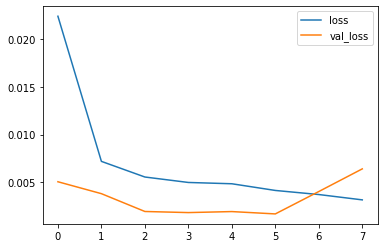

In [291]:
frozen_prod_model_hist[['loss','val_loss']].plot()

#Model Testing and Prediction

In [294]:
test_pred=[];
first_sequence=train_df_scaled[-seq_len:];
eval_batch=first_sequence.reshape((1,seq_len,n_features));
for i in range(pred):
    current_pred=frozen_prod_model.predict(eval_batch);
    test_pred.append(current_pred[0]);
    eval_batch=np.append(eval_batch[:,1:,:],[[current_pred[0]]],axis=1);

In [295]:
yhat=scaler.inverse_transform(test_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


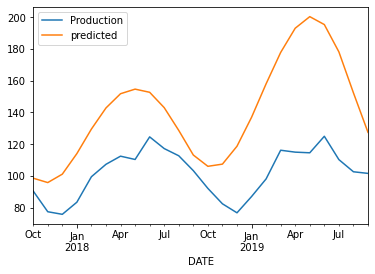

In [296]:
test_df['predicted']=yhat;
test_df.plot()
#Model does capture the overall trend although with an error

In [335]:
#RMSE
rmse=np.sqrt(np.sum(np.abs((test_df['predicted']-test_df['Production'])/df['Production'])))
print('RMSE for model',rmse)

RMSE for model 3.0253823584422386


# Forecasting Model

In [306]:
#Forecast Model Building
#Model 
hidden_states=100;
n_features=1;
fc_frozen_prod_model=Sequential()
fc_frozen_prod_model.add(LSTM(hidden_states,activation='relu',input_shape=(seq_len,n_features)))
fc_frozen_prod_model.add(Dense(1,activation='relu'))
fc_frozen_prod_model.compile(loss='mse',optimizer='adam')
fc_frozen_prod_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 100)               40800     
                                                                 
 dense_14 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [307]:

#Fitting Model
#epochs=6 taken from previous test model
fc_frozen_prod_model.fit_generator(fgenerator,epochs=6)

Epoch 1/6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


561/561 [==============================] - 5s 6ms/step - loss: 0.0471
Epoch 2/6
561/561 [==============================] - 4s 6ms/step - loss: 0.0099
Epoch 3/6
561/561 [==============================] - 4s 7ms/step - loss: 0.0067
Epoch 4/6
561/561 [==============================] - 4s 6ms/step - loss: 0.0055
Epoch 5/6
561/561 [==============================] - 4s 6ms/step - loss: 0.0046
Epoch 6/6
561/561 [==============================] - 4s 6ms/step - loss: 0.0044


In [308]:
#Forecasting
test_pred=[];
first_sequence=df_scaled[-seq_len:];
eval_batch=first_sequence.reshape((1,seq_len,n_features));
for i in range(pred):
    current_pred=fc_frozen_prod_model.predict(eval_batch);
    test_pred.append(current_pred[0]);
    eval_batch=np.append(eval_batch[:,1:,:],[[current_pred[0]]],axis=1);
forecast=full_scaler.inverse_transform(test_pred)

In [ ]:
plt.plot(forecast)

In [310]:
df.tail(2)

,Production
DATE,
2019-08-01,102.6085
2019-09-01,101.5866


In [313]:
forecast_period=pd.date_range(start='2019-09-01',periods=pred,freq='MS')

In [314]:
forecast_pred=pd.DataFrame(forecast,index=forecast_period)

Text(0, 0.5, 'Production Index')

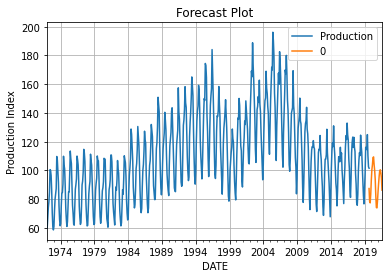

In [324]:

#Forecast Plot
ax=df.plot()
forecast_pred.plot(ax=ax)
plt.grid(True)
plt.title('Forecast Plot')
plt.ylabel('Production Index')

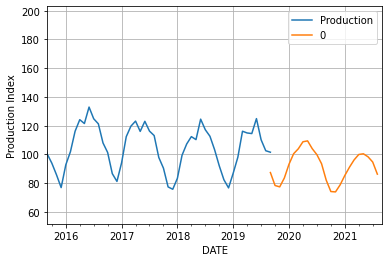

In [327]:
#Zoomed in plot
ax=df.plot();
forecast_pred.plot(ax=ax);
plt.grid(True);
plt.ylabel('Production Index');
plt.xlim(['2015-09-01','2021-09-01']);


###The forecast shows a decreasing trend in production index of frozen desserts which seems to follow the previous few year trend. 
###The forecast is smoother than actual data with lesser high frequency fluctuations. Its more or less in line with previous year trends and the seasonality is also captured by it.
###However, this can be improved by changing the number of hidden states in LSTM layer or changing the sequence length and the training epochs.